# Plateau angle simulation
## Goal
The goal of this part is to create a simulation of the relationship between inputs and the motor angles. To do so, a neural network will be trained, using pytorch, in order to simulate the system.

## External imports

In [1]:
import numpy as np
import pandas as pd
import csv
import os
import matplotlib
import matplotlib.pyplot as plt
import time
import json

from torch.autograd import Variable
from sklearn.linear_model import LinearRegression
from mpl_toolkits import mplot3d
from matplotlib import cm
from matplotlib.ticker import LinearLocator
from sklearn.metrics import r2_score

%matplotlib notebook

## Internal imports

In [2]:
from src import *
from src.constants import DT, MOTOR_SPEED_SCALING
print(DT)

0.02


## Data preparation

In this part, the recorded data are loaded and prepared. The goal is to train the neural network on those datas.

In [3]:
data = pd.read_csv('src/data/train/motor_id.csv')
test_data = pd.read_csv('src/data/test/motor_id_test.csv')

Data visualisation

<IPython.core.display.Javascript object>


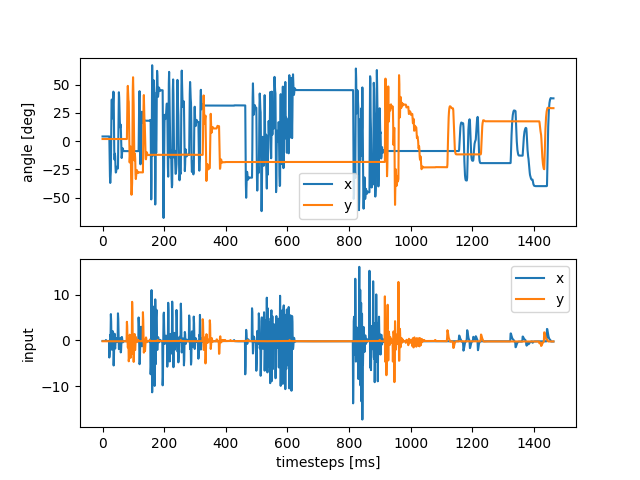

In [4]:
fig, axs = plt.subplots(2, 1)
    
axs[0].plot(data['angle_x'], label='x')
axs[0].plot(data['angle_y'], label='y')
axs[0].set_ylabel('angle [deg]')
axs[0].legend()
    
axs[1].plot(data['input_x'], label='x')
axs[1].plot(data['input_y'], label='y')
axs[1].set_xlabel('timesteps [ms]')
axs[1].set_ylabel('input')
axs[1].legend()
    
plt.show()

<IPython.core.display.Javascript object>


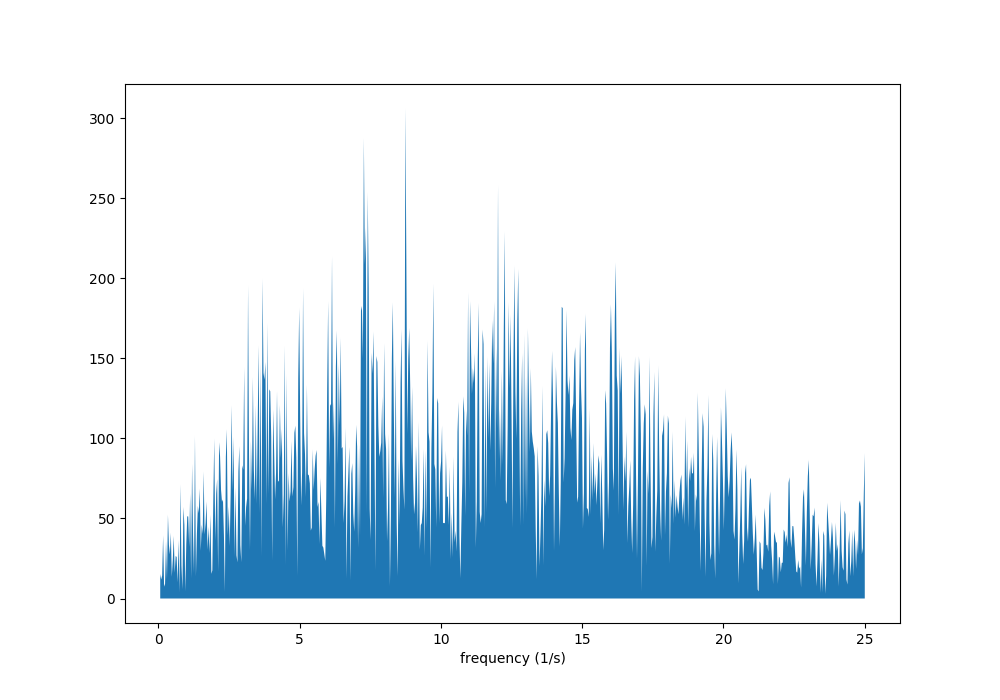

<IPython.core.display.Javascript object>


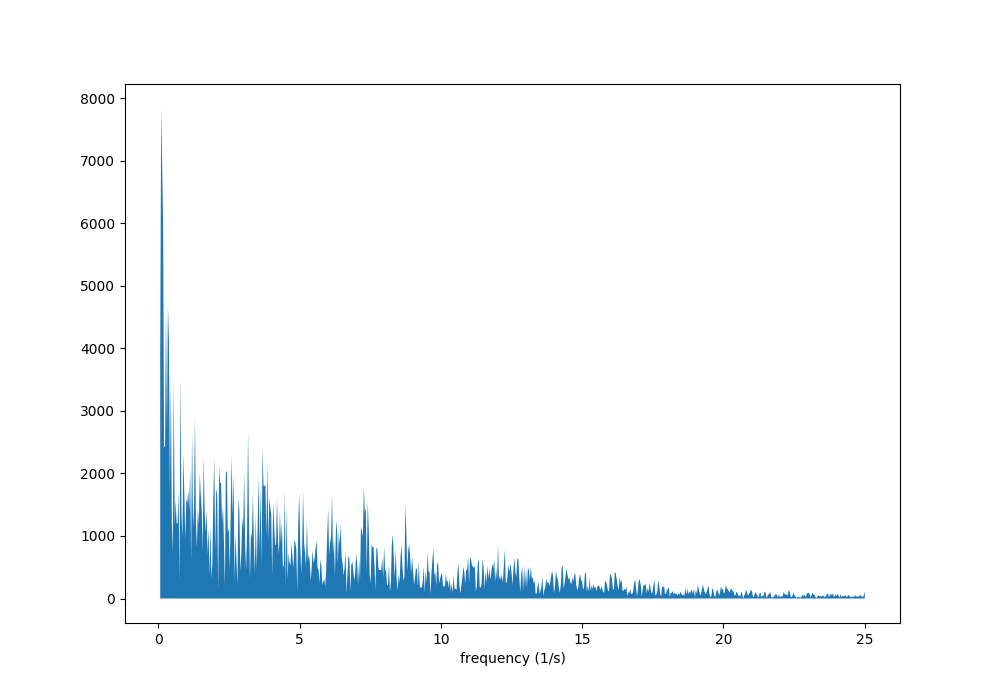

In [5]:
l = len(data['angle_x'])
ft_x = np.abs(np.fft.rfft(data['angle_x']))
ft_y = np.abs(np.fft.rfft(data['input_x']))
freq = np.fft.rfftfreq(l) / DT

plt.figure(figsize=(10, 7))
plt.fill_between(freq[2:], ft_y[2:])

plt.xlabel('frequency (1/s)')
plt.show()

plt.figure(figsize=(10, 7))
plt.fill_between(freq[2:], ft_x[2:])

plt.xlabel('frequency (1/s)')
plt.show()

The input of the NN will be the inputs and speed. Thus, it is computed for each dataset.

The prediction of the neural network will be the speed to the next timestep.

All datasets are concatened and shuffled in order to have no-biased gradients during the training

Since the data is symetrical, it is possible to double it by adding the opposite measurements

     x    y  angle_x  angle_y  input_x  input_y
0  0.0  0.0    4.179    1.929   -0.101   -0.161
1  0.0  0.0    4.179    1.929   -0.101   -0.161
2  0.0  0.0    4.179    1.929   -0.101   -0.161
3  0.0  0.0    4.179    1.929   -0.101   -0.161
4  0.0  0.0    4.179    1.929   -0.100   -0.161
     x    y  angle_x  angle_y  input_x  input_y
0  0.0  0.0   36.964      0.0   -0.147   -0.155
1  0.0  0.0   36.964      0.0   -0.148   -0.155
2  0.0  0.0   36.964      0.0   -0.149   -0.155
3  0.0  0.0   36.964      0.0   -0.150   -0.155
4  0.0  0.0   36.964      0.0   -0.151   -0.155


<IPython.core.display.Javascript object>


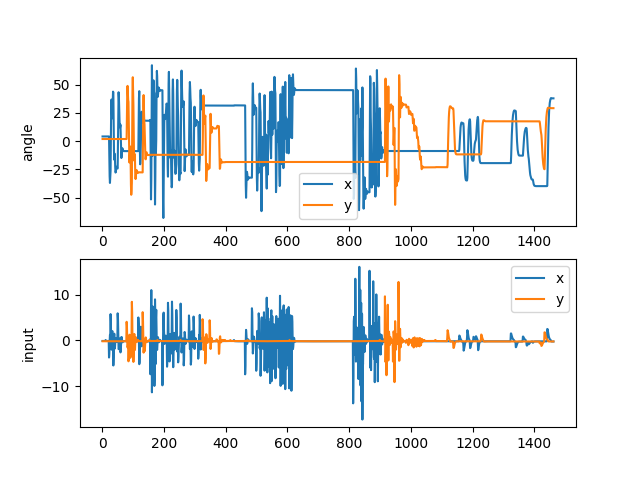

In [6]:
print(data.head())
data['d_angle_x'] = (data['angle_x'] - data['angle_x'].shift(1)) / DT
data['d_angle_y'] = (data['angle_y'] - data['angle_y'].shift(1)) / DT
data['target_x'] = data['d_angle_x'].shift(-1)
data['target_y'] = data['d_angle_y'].shift(-1)
data.dropna(inplace=True)

print(test_data.head())
test_data['d_angle_x'] = (test_data['angle_x'] - test_data['angle_x'].shift(1)) / DT
test_data['d_angle_y'] = (test_data['angle_y'] - test_data['angle_y'].shift(1)) / DT
test_data['target_x'] = test_data['d_angle_x'].shift(-1)
test_data['target_y'] = test_data['d_angle_y'].shift(-1)
test_data.dropna(inplace=True)

fig, axs = plt.subplots(2, 1)
    
axs[0].plot(data['angle_x'], label='x')
axs[0].plot(data['angle_y'], label='y')
axs[0].set_ylabel('angle')
axs[0].legend()
    
axs[1].plot(data['input_x'], label='x')
axs[1].plot(data['input_y'], label='y')
axs[1].set_ylabel('input')
axs[1].legend()
    
plt.show()

<IPython.core.display.Javascript object>


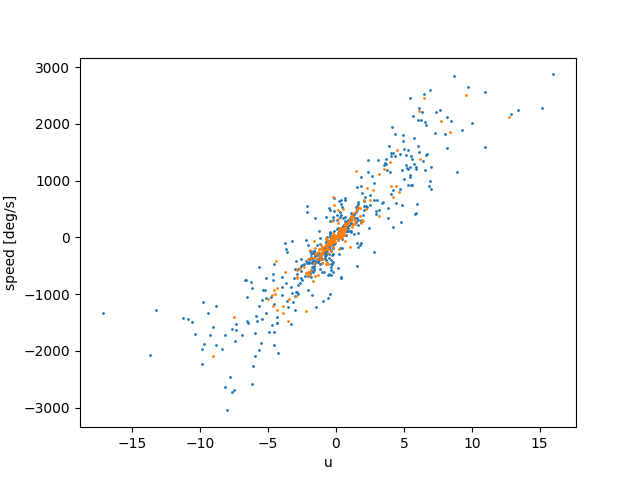

In [7]:
plt.figure()

plt.scatter(data['input_x'], data['target_x'], s=1)
plt.scatter(data['input_y'], data['target_y'], s=1)
plt.xlabel("u")
plt.ylabel("speed [deg/s]")
plt.show()

<IPython.core.display.Javascript object>


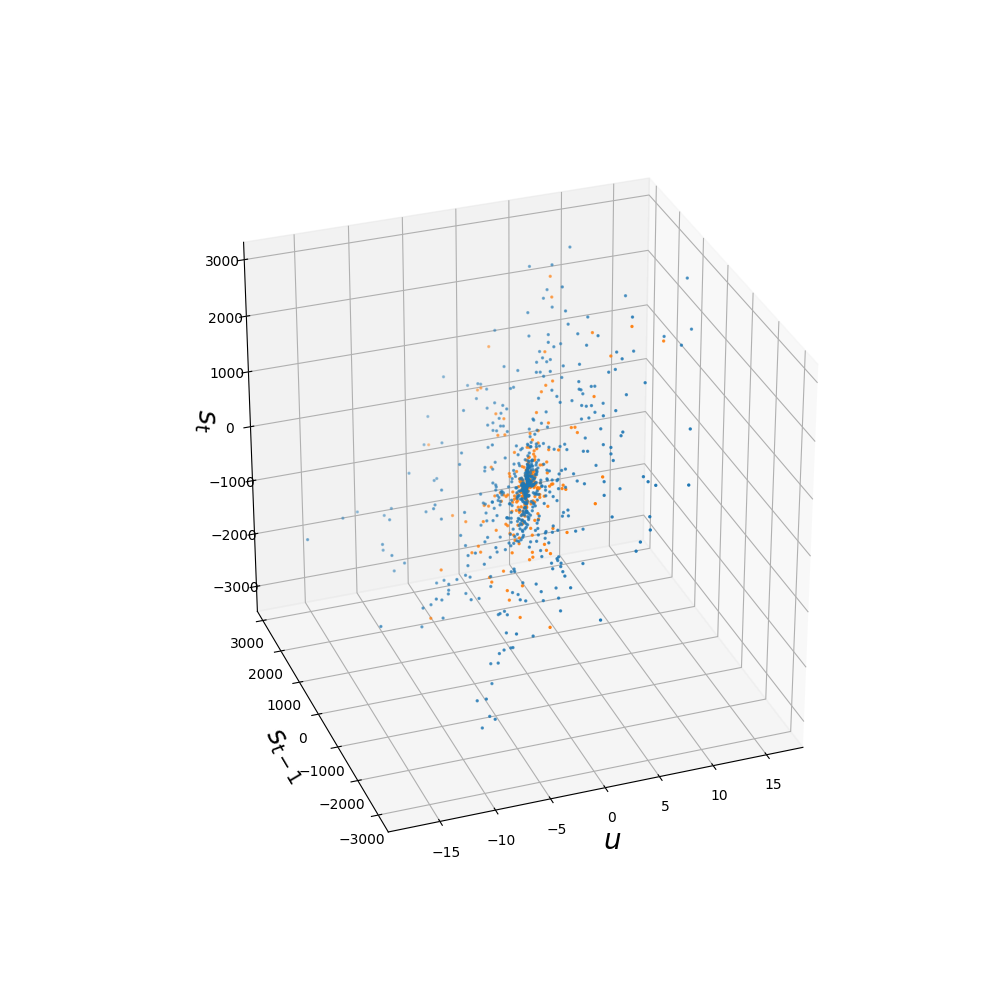

Text(0.5, 0, '$s_{t}$')

In [8]:
plt.figure()
ax = plt.axes(projection='3d')
ax.view_init(30, -110)
ax.scatter3D(data['input_x'], data['d_angle_x'], data['target_x'], s=2)
ax.scatter3D(data['input_y'], data['d_angle_y'], data['target_y'], s=2)
ax.figure.set_size_inches(10, 10)
plt.show()
ax.set_xlabel('$u$', fontsize=20)
ax.set_ylabel('$s_{t-1}$', fontsize=20)
ax.set_zlabel('$s_{t}$', fontsize=20)

In [9]:
data.head()

,x,y,angle_x,angle_y,input_x,input_y,d_angle_x,d_angle_y,target_x,target_y
1,0.0,0.0,4.179,1.929,-0.101,-0.161,0.0,0.0,0.0,0.0
2,0.0,0.0,4.179,1.929,-0.101,-0.161,0.0,0.0,0.0,0.0
3,0.0,0.0,4.179,1.929,-0.101,-0.161,0.0,0.0,0.0,0.0
4,0.0,0.0,4.179,1.929,-0.100,-0.161,0.0,0.0,0.0,0.0
5,0.0,0.0,4.179,1.929,-0.100,-0.161,0.0,0.0,0.0,0.0


In [10]:
len(data)

1462

## Physical Model
In this section, the motor dynamics will be derived from the physic. The produced model will be the benchmark for the next steps.

### Equations
The speed equation of a DC motor is:
n = (V_m - R_m * I_a) / k_b / W_b

Since I_a is our only dynamic variable, we can symplify this equation to:
n = a * x + b
which is a simple linear regression.

Many models are proposed

In [11]:
# Motor_x and y independant
A_x = np.ones((len(data), 2))
A_x[:, 1] = data['input_x'].to_numpy()
B_x = data['target_x'].to_numpy().reshape(-1, 1)

A_y = np.ones((len(data), 2))
A_y[:, 1] = data['input_y'].to_numpy()
B_y = data['target_y'].to_numpy().reshape(-1, 1)

# Identical motor hypothesis
A = np.vstack((A_x, A_y))
B = np.vstack((B_x, B_y))


phy_motor_x = LinearRegression().fit(A_x, B_x)
phy_motor_y = LinearRegression().fit(A_y, B_y)
phy_motor = LinearRegression().fit(A, B)

print("Ide motor\nx coefs:", phy_motor_x.coef_, "  ", phy_motor_x.score(A_x, B_x))
print("y coefs: ", phy_motor_y.coef_, "\n")
print("Identical hyp\nCoefs: ", phy_motor.coef_, "  ", phy_motor_x.score(A_y, B_y))

Ide motor
x coefs: [[  0.         213.89497696]]    0.8182886591473965
y coefs:  [[  0.         242.48072454]] 

Identical hyp
Coefs:  [[  0.         217.59587894]]    0.8670514288212582


Let's test those models

It is possible to see some steady state error. Using the 3D plot, it is possible to see that the inertia component of the motor is missing. Thus, the transition regimes must be unaccurate.

It is also possible to use a simplified model, without an intercept (symetric)

Finally, it seems usless to treat each motor independentely

Leading to:

n = (V_m - R_m * I_a) / k_b / W_b + n * coef

=>   n = a * x + b

In [12]:
# Inertia motor
A = np.vstack((data[['input_x', 'd_angle_x']].to_numpy(), data[['input_y', 'd_angle_y']].to_numpy()))
A[:, 1] = A[:, 1] / MOTOR_SPEED_SCALING

phy_motor_inertia = LinearRegression().fit(A, B)

print("Inertia motor\nx coefs:", phy_motor_inertia.coef_)

Inertia motor
x coefs: [[ 217.17632054 7274.25034004]]


In [13]:
def recurcive_predict(s_0: float, a_u: float, a_s: float, u: np.ndarray) -> np.ndarray:
    s = np.zeros_like(u)
    s[0] = s_0  
    for i in range(1, len(u)):
        s[i] = a_u * u[i-1] + a_s / 20000. * s[i-1]
    return s  

In [14]:
test_data['y_hat_x_phy_motor_x'] = test_data['input_x'].to_numpy() * phy_motor_x.coef_[0][1]
test_data['y_hat_y_phy_motor_y'] = test_data['input_y'].to_numpy() * phy_motor_y.coef_[0][1]
    
test_data['y_hat_x_phy_motor'] = test_data['input_x'].to_numpy() * phy_motor.coef_[0][1]
test_data['y_hat_y_phy_motor'] = test_data['input_y'].to_numpy() * phy_motor.coef_[0][1]
    
test_data['y_hat_x_motor_inertia'] = recurcive_predict(test_data['d_angle_x'].iloc[0], phy_motor_inertia.coef_[0][0], phy_motor_inertia.coef_[0][1], test_data['input_x'].to_numpy())
test_data['y_hat_y_motor_inertia'] = recurcive_predict(test_data['d_angle_y'].iloc[0], phy_motor_inertia.coef_[0][0], phy_motor_inertia.coef_[0][1], test_data['input_y'].to_numpy())
    
test_data['angle_hat_x_phy_motor_x'] = s_to_p(test_data['angle_x'].iloc[0], test_data['y_hat_x_phy_motor_x'].to_numpy(), DT)
test_data['angle_hat_y_phy_motor_y'] = s_to_p(test_data['angle_y'].iloc[0], test_data['y_hat_y_phy_motor_y'].to_numpy(), DT)
    
test_data['angle_hat_x_phy_motor'] = s_to_p(test_data['angle_x'].iloc[0], test_data['y_hat_x_phy_motor'].to_numpy(), DT)
test_data['angle_hat_y_phy_motor'] = s_to_p(test_data['angle_y'].iloc[0], test_data['y_hat_y_phy_motor'].to_numpy(), DT)
    
test_data['angle_hat_x_phy_motor_inertia'] = s_to_p(test_data['angle_x'].iloc[0], test_data['y_hat_x_motor_inertia'].to_numpy(), DT)
test_data['angle_hat_y_phy_motor_inertia'] = s_to_p(test_data['angle_y'].iloc[0], test_data['y_hat_y_motor_inertia'].to_numpy(), DT)

# Neural network training
Since the motors behavior isn't linear, multiples NN are created and trained to model the system.

Due to the previous overvations, both motors have been considered identical.

The inputs and targets are converted into pytorch format

In [15]:
x_np = np.vstack(
            (data[['input_x', 'd_angle_x']].to_numpy(), data[['input_y', 'd_angle_y']].to_numpy())
        )
x_np[:, 1] = x_np[:, 1] / MOTOR_SPEED_SCALING

x = Variable(
    torch.from_numpy(
        x_np
    ).type(torch.FloatTensor)
)

y = Variable(
    torch.from_numpy(
        np.vstack(
            (data[['target_x']].to_numpy(), data[['target_y']].to_numpy())
        )
    ).type(torch.FloatTensor)
)

In [16]:
nets = [PlateauNet1Hidden(2, 8, 1), PlateauNet1Hidden(2, 16, 1), PlateauNet1Hidden(2, 32, 1), 
        PlateauNet1Hidden(2, 64, 1), PlateauNet2Hidden(2, 8, 8, 1), PlateauNet2Hidden(2, 16, 8, 1),
       PlateauNet2Hidden(2, 32, 16, 1), PlateauNet2Hidden(2, 64, 32, 1), PlateauNet2Hidden(2, 64, 64, 1)]

In [17]:
nets = [train_plateau_model(net, x, y, n_epoch=5000) for net in nets]

tensor(31477.6875, grad_fn=<MseLossBackward>) 0.8018734654111376
tensor(30188.0508, grad_fn=<MseLossBackward>) 0.8107010310685906
tensor(30122.6035, grad_fn=<MseLossBackward>) 0.8110011947215771
tensor(29735.3633, grad_fn=<MseLossBackward>) 0.8136368097582072
tensor(7359.8296, grad_fn=<MseLossBackward>) 0.9519349026033671
tensor(5136.6870, grad_fn=<MseLossBackward>) 0.9694871347931994
tensor(9660.5859, grad_fn=<MseLossBackward>) 0.9272952663583588
tensor(9426.2695, grad_fn=<MseLossBackward>) 0.9294149411202512
tensor(7137.5146, grad_fn=<MseLossBackward>) 0.9511389220290267


In [18]:
best_index = 7

test_data['y_hat_x_motor_nn'] = nets[best_index].recurcive_predict(test_data['d_angle_x'].iloc[0], test_data['input_x'].to_numpy())
test_data['y_hat_y_motor_nn'] = nets[best_index].recurcive_predict(test_data['d_angle_y'].iloc[0], test_data['input_y'].to_numpy())
    
test_data['angle_hat_x_nn'] = s_to_p(test_data['angle_x'].iloc[0], test_data['y_hat_x_motor_nn'].to_numpy(), DT)
test_data['angle_hat_y_nn'] = s_to_p(test_data['angle_y'].iloc[0], test_data['y_hat_y_motor_nn'].to_numpy(), DT)

## Tests

# Long run prediction

<IPython.core.display.Javascript object>


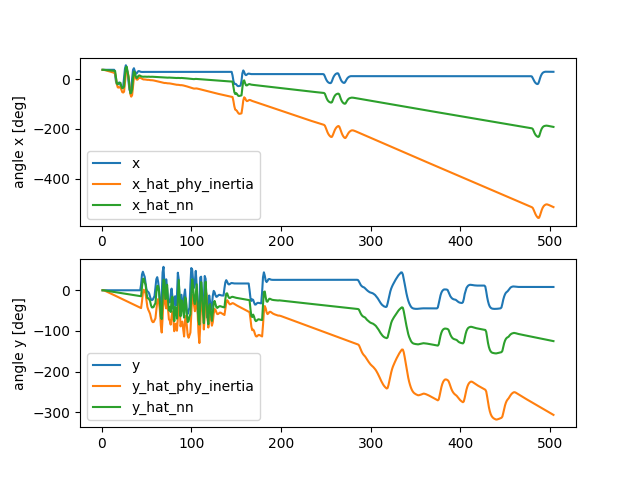

In [22]:
fig, axs = plt.subplots(2, 1)
    
axs[0].plot(test_data['angle_x'], label='x')
#axs[0].plot(test_data['angle_hat_x_phy_motor'], label='x_hat_phy')
axs[0].plot(test_data['angle_hat_x_phy_motor_inertia'], label='x_hat_phy_inertia')
axs[0].plot(test_data['angle_hat_x_nn'], label='x_hat_nn')
    
axs[0].set_ylabel('angle x [deg]')
axs[0].legend()
    
axs[1].plot(test_data['angle_y'], label='y')
#axs[1].plot(test_data['angle_hat_y_phy_motor'], label='y_hat_phy')
axs[1].plot(test_data['angle_hat_y_phy_motor_inertia'], label='y_hat_phy_inertia')
axs[1].plot(test_data['angle_hat_y_nn'], label='y_hat_nn')
axs[1].set_ylabel('angle y [deg]')
axs[1].legend()

## One step prediction

In [20]:
print("Physic motor : ", phy_motor.score(x, y))
print("Physic motor inertia : ", phy_motor_inertia.score(x, y))
print("NN motor : ", r2_score(nets[best_index].forward(x).detach().numpy(), y))

Physic motor :  0.004158540085614559
Physic motor inertia :  0.9581813837879646
NN motor :  0.9725043821666234


In [21]:
torch.save(nets[best_index], 'src/data/motor_nn.pt')

/home/benoit/.local/lib/python3.6/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type PlateauNet2Hidden. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/benoit/.local/lib/python3.6/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Linear. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [22]:
# json saving
motor = {
    'phy_coef': phy_motor.coef_[0][1],
    'phy_i_coef_u': phy_motor_inertia.coef_[0][0],
    'phy_i_coef_s': phy_motor_inertia.coef_[0][1],
    'speed_scaling': MOTOR_SPEED_SCALING
}

with open('src/data/motor.json', 'w') as json_file:
    json.dump(motor, json_file)

## Conclusion
Given those results, the best motor is the neural network, but the physical model with inertia has almost the same test metrics while being 33 times faster.

The physical model has the best properties to be the training model. The neural network model, on its side has the best properties to be the testing model.

Here is the visualisation of their behavior topologies

In [23]:
net = torch.load('src/data/motor_nn.pt')

X = np.arange(-10, 10, 0.5)
Y = np.arange(-4000, 4000, 100)
X, Y = np.meshgrid(X, Y)
start = time.time()
Z = np.array([[net.step(x, y).item() for x, y in zip(x_row, y_row)] for x_row, y_row in zip(X, Y)])
t = time.time() - start
print("NN time :", t)

start = time.time()
Z_lin = np.array([[phy_motor_inertia.coef_[0][1] * x for x, y in zip(x_row, y_row)] for x_row, y_row in zip(X, Y)])
t_lin = time.time() - start
print("Lin time :", t_lin)

start = time.time()
Z_lin_i = np.array([[phy_motor_inertia.coef_[0][0] * x + y / 20000. * phy_motor_inertia.coef_[0][1] for x, y in zip(x_row, y_row)] for x_row, y_row in zip(X, Y)])
t_lin_i = time.time() - start
print("Lin inertia time :", t_lin_i)

print("\nRatio :", t / t_lin)
print("Ratio inertia :", t / t_lin_i)

NN time : 0.7399945259094238
Lin time : 0.0076313018798828125
Lin inertia time : 0.026370763778686523

Ratio : 96.96832041989502
Ratio inertia : 28.061171535255454


<IPython.core.display.Javascript object>


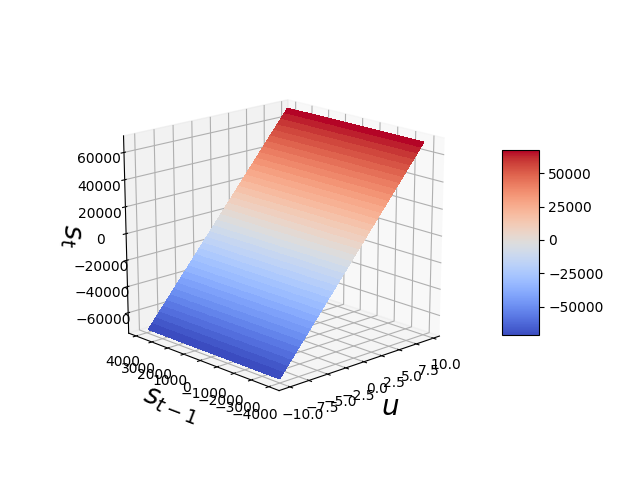

<IPython.core.display.Javascript object>


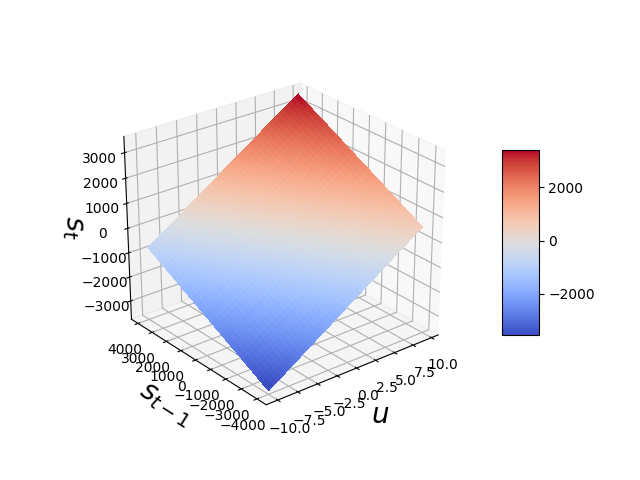

<IPython.core.display.Javascript object>


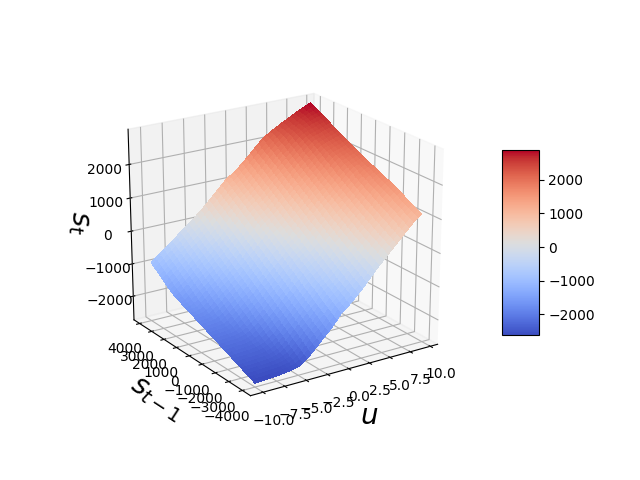

In [24]:
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
ax.view_init(30, 120)
# Plot the surface.
surf = ax.plot_surface(X, Y, Z_lin, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
ax.set_xlabel('$u$', fontsize=20)
ax.set_ylabel('$s_{t-1}$', fontsize=20)
ax.set_zlabel('$s_{t}$', fontsize=20)

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
ax.view_init(30, 120)
# Plot the surface.
surf = ax.plot_surface(X, Y, Z_lin_i, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
ax.set_xlabel('$u$', fontsize=20)
ax.set_ylabel('$s_{t-1}$', fontsize=20)
ax.set_zlabel('$s_{t}$', fontsize=20)

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
ax.view_init(30, 120)
# Plot the surface.
surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
ax.set_xlabel('$u$', fontsize=20)
ax.set_ylabel('$s_{t-1}$', fontsize=20)
ax.set_zlabel('$s_{t}$', fontsize=20)

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()